# Import the necesary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Helper Functions



In [2]:
def plot_timeseries(xV, get_histogram=False, title='', savepath=''):
    # #plot timeseries
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    ax.plot(xV, marker='x', linestyle='--', linewidth=2);
    ax.set_xlabel('time')
    ax.set_ylabel('value')
    if len(title) > 0:
        ax.set_title(title, x=0.5, y=1.0);
    plt.tight_layout()
    if len(savepath) > 0:
        plt.savefig(f'{savepath}/{title}_xM.jpeg')
    # #plot histogram
    if get_histogram:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.hist(xV, alpha=0.8, rwidth=0.9);
        ax.set_xlabel('value')
        ax.set_title('Histogram')
        plt.tight_layout()
        if len(title) > 0:
            ax.set_title(title, x=0.5, y=1.0);
        plt.tight_layout()
        if len(savepath) > 0:
            plt.savefig(f'{savepath}/{title}_hist.jpeg')

def seasonal_components(xV, period):
    '''
    computes the periodic time series comprised of repetetive
    patterns of seasonal components given a time series and the season
    (period).
    '''
    n = xV.shape[0]
    sV = np.full(shape=(n,), fill_value=np.nan)
    monV = np.full(shape=(period,), fill_value=np.nan)
    for i in np.arange(period):
        monV[i] = np.mean(xV[i:n:period])
    monV = monV - np.mean(monV)
    for i in np.arange(period):
        sV[i:n:period] = monV[i] * np.ones(shape=len(np.arange(i, n, period)))
    return sV


# Preprocess the data

In [3]:
data_df = pd.read_csv('train.csv')
team_number = 11
team_data = data_df.iloc[:, team_number + 1]

#turn the data into a numpy array
team_data = team_data.to_numpy()

#find the consecutive values
same_val_index = np.where(np.diff(team_data) == 0)

print(f"Value {team_data[same_val_index[0][0]]} at index {same_val_index[0][0]} ")
print(f"Value {team_data[same_val_index[0][0] + 1]} at index {same_val_index[0][0] + 1} ")
print(f"Value {team_data[same_val_index[0][1]]} at index {same_val_index[0][1]} ")
print(f"Value {team_data[same_val_index[0][1] + 1]} at index {same_val_index[0][1] + 1} ")

# Replace the consecutive values with the mean of two values
#check if index - 365 < 0 and index + 365 > len(team_data)

for index in same_val_index[0]:
    if index - 365 < 0:
        print(f"First year of data.")
        team_data[index+1] = team_data[index+1+365]
    elif index + 365 > len(team_data):
        print(f"Last year of data.")
        team_data[index+1] = team_data[index+1-365]
    else:
        print(f"Middle of data.")
        team_data[index+1] = (team_data[index+1-365] + team_data[index+1+365])/2



    






Value 24058500 at index 89 
Value 24058500 at index 90 
Value 12694200 at index 388 
Value 12694200 at index 389 
First year of data.
Middle of data.


In [4]:
A = np.copy(team_data)


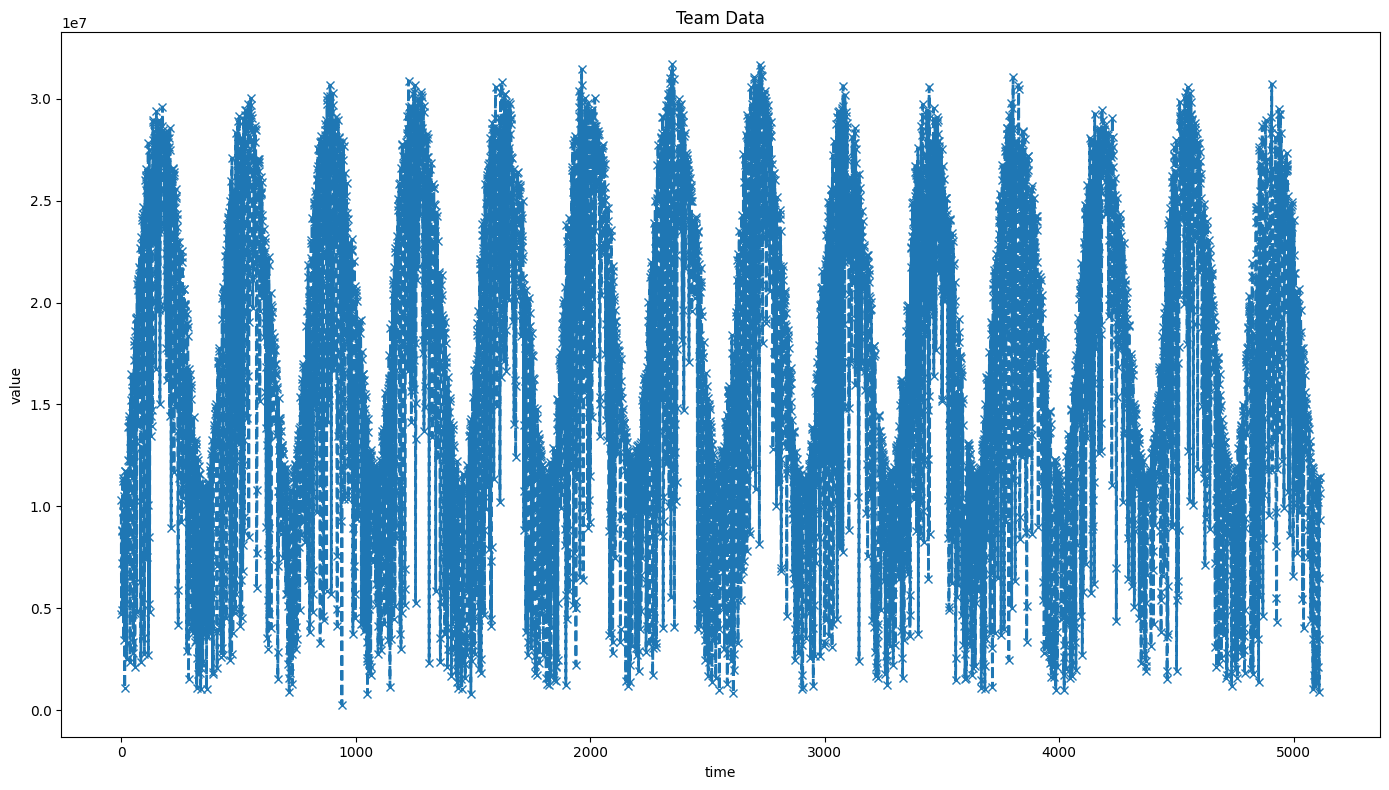

In [5]:
plot_timeseries(A,title='Team Data')

# Question 1

- Assume that A has no trend
- Remove Seasonality (can assume that s = 365)

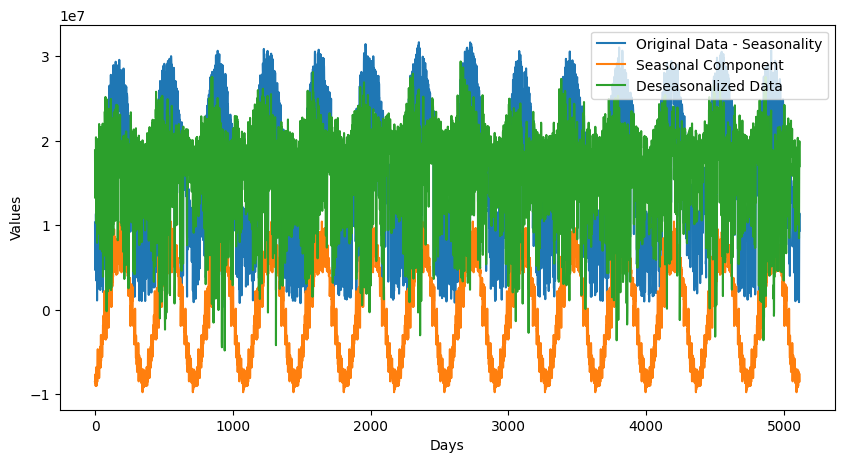

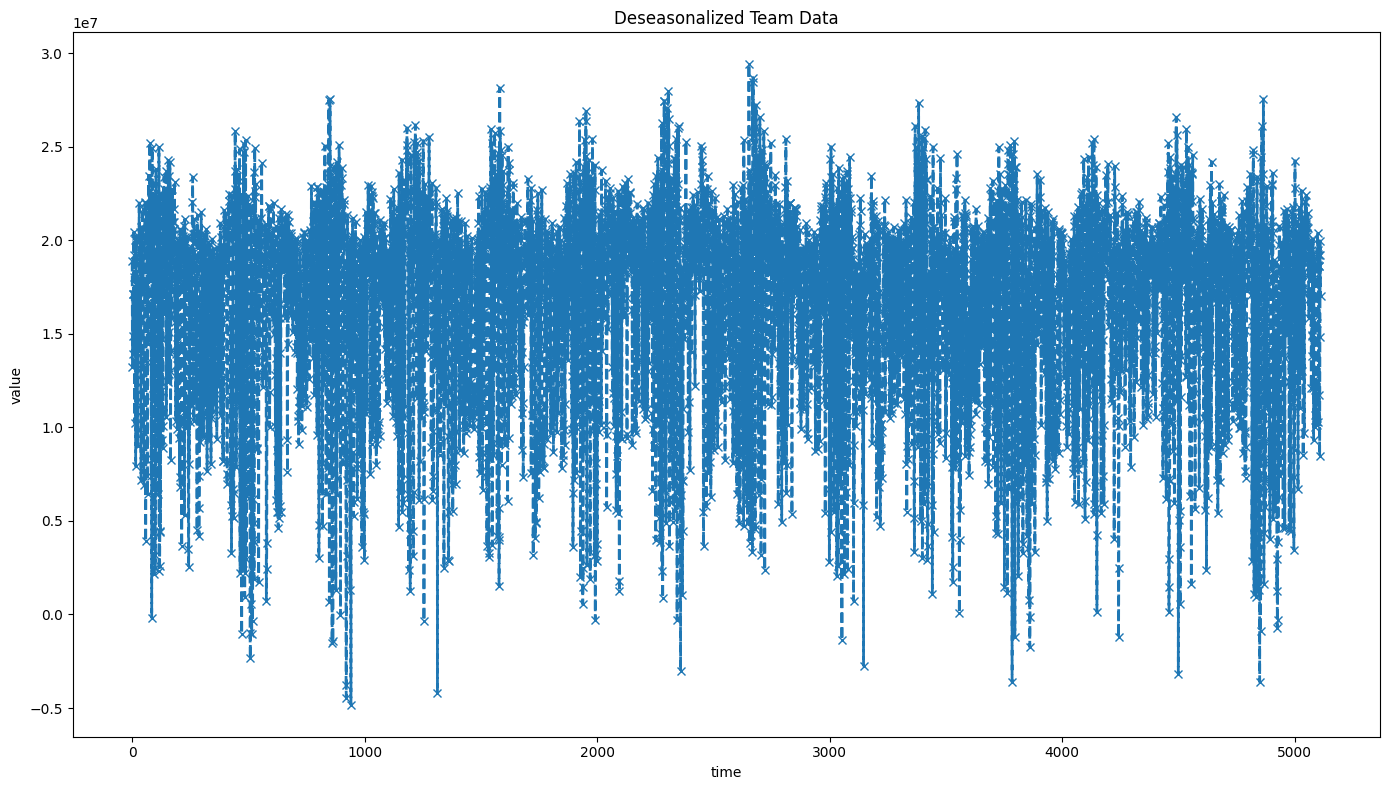

In [ ]:
# just subtract s =365
T_season = 365
s = seasonal_components(A, T_season)
A_static= A - s
plt.figure(figsize=(10,5))
plt.plot(A,label='Original Data - Seasonality')
plt.plot(s,label="Seasonal Component")
plt.plot(A_static,label='Deseasonalized Data')
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.show()



# Question 2

- Investigate if the `A_static` is White Noise (WN).
- A time series is considered White Noise (WN) if it satisfies the following conditions:
  1. **Mean**: \( E[X_t] = 0 \), for each \( t \).
  2. **Variance**: \( \text{Var}[X_t] = \sigma^2 \), constant for each \( t \).
  3. **Covariance**: \( \text{Cov}(X_t, X_{t+k}) = 0 \), meaning the observations are independent from one another.
